<a href="https://colab.research.google.com/github/cailucky777/AlgorithmPaper_group5/blob/main/AAGroup5Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Group 5 Members:
- Jacky
- Savina
- Bryan
- Nicky

##Project: LightGBM Modern Algorithm

## Project Overview: Comparing ML Models on Porto Seguro Driver Data

This project explores how different tree-based machine learning models perform when trying to predict whether a car insurance customer will file a claim next year. The dataset comes from **Kaggle's Porto Seguro’s Safe Driver Prediction** challenge.

* `0` → no insurance claim made
* `1` → insurance claim was made

We’re trying to **predict the probability** of someone making a claim based on their profile.

## Models Compared

Three popular (and fairly different) tree-based models:

### 1. Decision Tree

* Basic model, quick and interpretable.
* Tends to **overfit** and usually doesn't do well on more complex patterns.

### 2. Random Forest

* Takes decision trees and averages them out.
* Helps reduce overfitting and gives more stable results than a single tree.
* Can be slow depending on number of trees or the dataset is big.

### 3. LightGBM (Light Gradient Boosting Machine)

* Newer and very efficient gradient boosting framework from Microsoft.
* Known for **speed and accuracy**, especially when you’re dealing with a ton of features or big datasets.
* Slightly more difficult to tune.

## Metrics

### AUC (Area Under the ROC Curve)

* AUC tells me how well the model separates claimers vs. non-claimers.
* Good for **imbalanced datasets**, which this one definitely is.
* **Higher is better**. A perfect model would get 1.0

### Training Time (in seconds)

* How long each model takes to train.
* It helps to understand how scalable or efficient the model is

## Main Goal

* Which model is **most accurate** (i.e., has the highest AUC)?
* Which one is the **fastest** to train?
* How do they each behave when the dataset gets bigger?
* Is LightGBM the best when compared to older methods?



In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [29]:
import pandas as pd

# Load the training and test datasets from Google Drive
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/zillow/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/zillow/test.csv")

# NOTE: experimented with downsampling earlier — might bring this back later if training ia too slow
# train = train.sample(frac=0.5, random_state=42)  # randomly keep 50% of training data
# test = test.sample(frac=0.5, random_state=42)    # same for test data

# Check on the shape — just to see what we're working with
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (595212, 59)
Test shape: (892816, 58)


# Data Cleanup and Splitting

In [30]:
TARGET = "target"
ignore = ["parcelid", "id"]

# Grab all other columns except target + IDs
feature_cols = [col for col in train.columns if col not in [TARGET] + ignore]

# Splitting out features and target
X = train[feature_cols].copy()
y = train[TARGET].copy()

print("Number of features being used:", len(feature_cols))

# --- Step 2: Handle missing values ---

# Simple median imputation
X = X.fillna(X.median())

# Apply same fill strategy to test set using train medians
test_features = test[feature_cols].copy()
test_features = test_features.fillna(X.median())

# --- Step 3: Train/validation split ---

# 20% for validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42  # same seed for reproducibility
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_valid.shape)

X_train.head()


Number of features being used: 57
Training set shape: (476169, 57)
Validation set shape: (119043, 57)


,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
39028,2,1,5,0,0,1,0,0,0,0,...,4,4,3,11,0,0,1,0,1,0
478420,0,1,7,1,0,0,1,0,0,0,...,8,1,3,6,0,1,0,1,0,0
547268,0,1,3,0,0,0,1,0,0,0,...,5,2,3,10,0,0,0,0,0,0
388290,0,3,4,0,0,1,0,0,0,0,...,2,3,1,10,0,1,0,0,0,0
63342,0,1,2,1,0,1,0,0,0,0,...,8,3,6,11,0,0,0,0,1,1


In [31]:
# We'll use this list again for Random Forest and LightGBM
results = []

dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=None  # could tune this later if needed
)

# Time
start_time = time.time()
dt_model.fit(X_train, y_train)
train_time = time.time() - start_time

dt_valid_probs = dt_model.predict_proba(X_valid)[:, 1]

# AUC
dt_auc = roc_auc_score(y_valid, dt_valid_probs)

print(f" Decision Tree AUC: {dt_auc:.4f}")
print(f" Training time: {train_time:.3f} seconds")

# Storing results for comparison later
results.append({
    "model": "Decision Tree",
    "auc": dt_auc,
    "train_time": train_time
})


 Decision Tree AUC: 0.5092
 Training time: 24.968 seconds


In [32]:
# Create model
lin_model = LinearRegression()

# Time
start_time = time.time()
lin_model.fit(X_train, y_train)
train_time = time.time() - start_time

lin_valid_preds = lin_model.predict(X_valid)
lin_valid_probs = np.clip(lin_valid_preds, 0, 1)

# AUC
lin_auc = roc_auc_score(y_valid, lin_valid_probs)

print(f"Linear Regression AUC: {lin_auc:.4f}")
print(f"Training time: {train_time:.3f} seconds")

# Save results for comparison
results.append({
    "model": "Linear Regression",
    "auc": lin_auc,
    "train_time": train_time
})


Linear Regression AUC: 0.6260
Training time: 2.884 seconds


In [33]:
#200 trees
rf_model = RandomForestClassifier(
    n_estimators=200,       # number of trees in the forest
    max_depth=None,         # let trees grow as deep as needed
    n_jobs=-1,
    random_state=42         # reproducibility
)

# Time
start_time = time.time()
rf_model.fit(X_train, y_train)
train_time = time.time() - start_time


rf_valid_probs = rf_model.predict_proba(X_valid)[:, 1]

# AUC
rf_auc = roc_auc_score(y_valid, rf_valid_probs)

print(f" Random Forest AUC: {rf_auc:.4f}")
print(f" Training time: {train_time:.3f} seconds")

# Save result for comparison
results.append({
    "model": "Random Forest",
    "auc": rf_auc,
    "train_time": train_time
})


 Random Forest AUC: 0.6056
 Training time: 489.595 seconds


In [34]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Time
start_time = time.time()
lgb_model.fit(X_train, y_train)
train_time = time.time() - start_time

lgb_valid_probs = lgb_model.predict_proba(X_valid)[:, 1]

# AUC
lgb_auc = roc_auc_score(y_valid, lgb_valid_probs)

print(f" LightGBM AUC: {lgb_auc:.4f}")
print(f" Training time: {train_time:.3f} seconds")

# Save result for comparison
results.append({
    "model": "LightGBM",
    "auc": lgb_auc,
    "train_time": train_time
})


[LightGBM] [Info] Number of positive: 17309, number of negative: 458860
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.163158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036351 -> initscore=-3.277519
[LightGBM] [Info] Start training from score -3.277519
 LightGBM AUC: 0.6356
 Training time: 42.897 seconds


=== Model Comparison (AUC vs. Training Time) ===
               model       auc  train_time
3           LightGBM  0.635624   42.897003
1  Linear Regression  0.626018    2.884094
2      Random Forest  0.605614  489.595006
0      Decision Tree  0.509212   24.967597


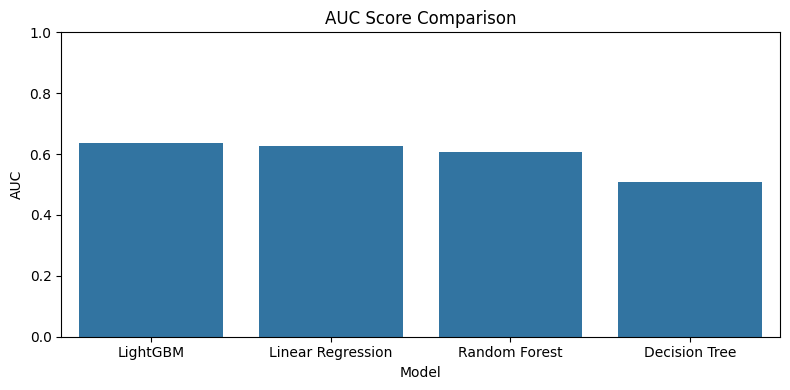

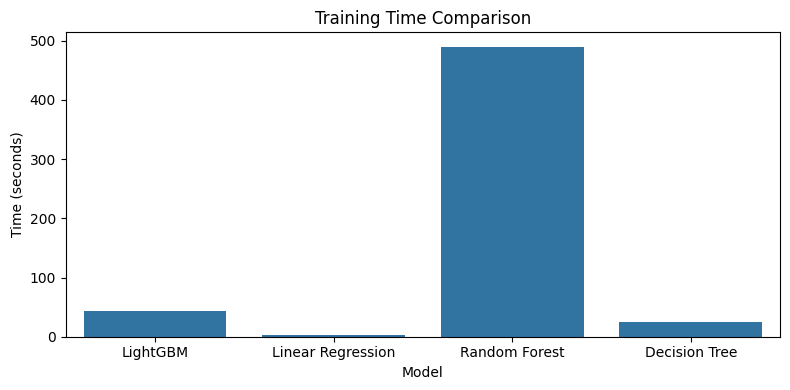

In [35]:
# Convert our list of results into a proper DataFrame
results_df = pd.DataFrame(results)

# Sort models by AUC
results_df = results_df.sort_values(by="auc", ascending=False)

print("=== Model Comparison (AUC vs. Training Time) ===")
print(results_df)


plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x="model", y="auc")
plt.title("AUC Score Comparison")
plt.ylim(0.0, 1.0)
plt.ylabel("AUC")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x="model", y="train_time")
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

/tmp/ipython-input-3997848243.py:26: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


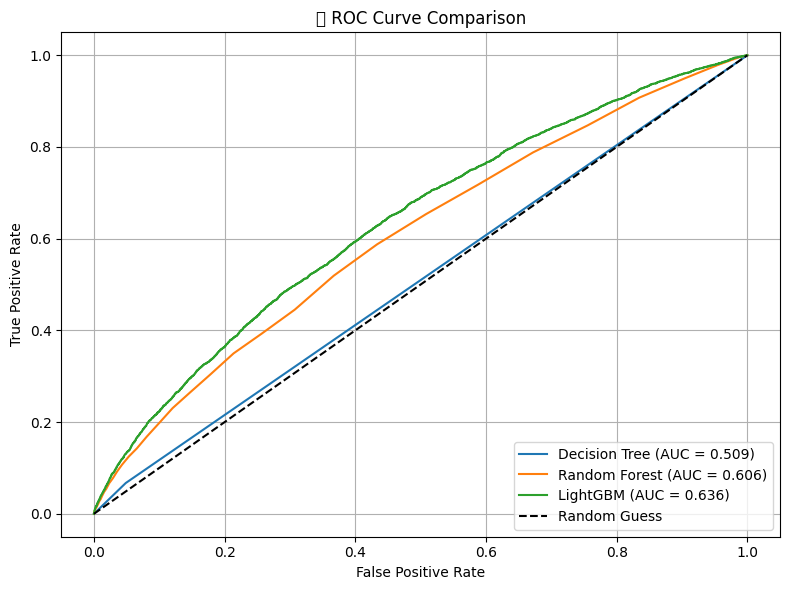

In [36]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

models = {
    "Decision Tree": dt_valid_probs,
    "Random Forest": rf_valid_probs,
    "LightGBM": lgb_valid_probs,
}

# Plot ROC curve for each model
for name, probs in models.items():
    fpr, tpr, _ = roc_curve(y_valid, probs)
    auc = roc_auc_score(y_valid, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Add diagonal line for reference
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


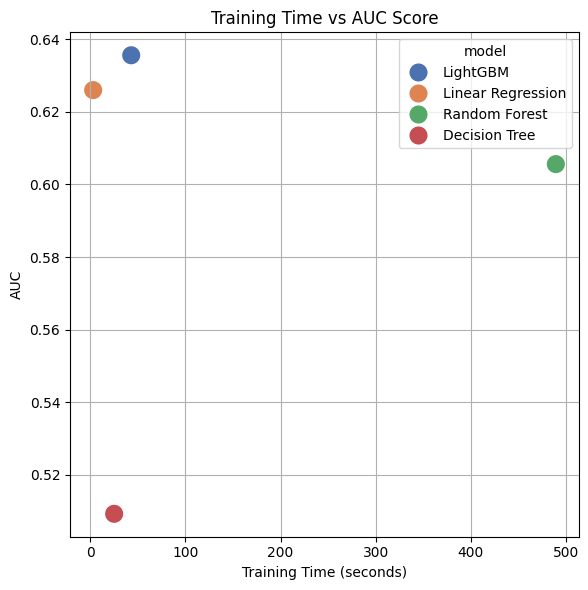

In [37]:
plt.figure(figsize=(6, 6))

sns.scatterplot(
    data=results_df,
    x="train_time",
    y="auc",
    hue="model",
    s=200,
    palette="deep"
)

plt.title("Training Time vs AUC Score")
plt.xlabel("Training Time (seconds)")
plt.ylabel("AUC")
plt.grid(True)
plt.tight_layout()
plt.show()


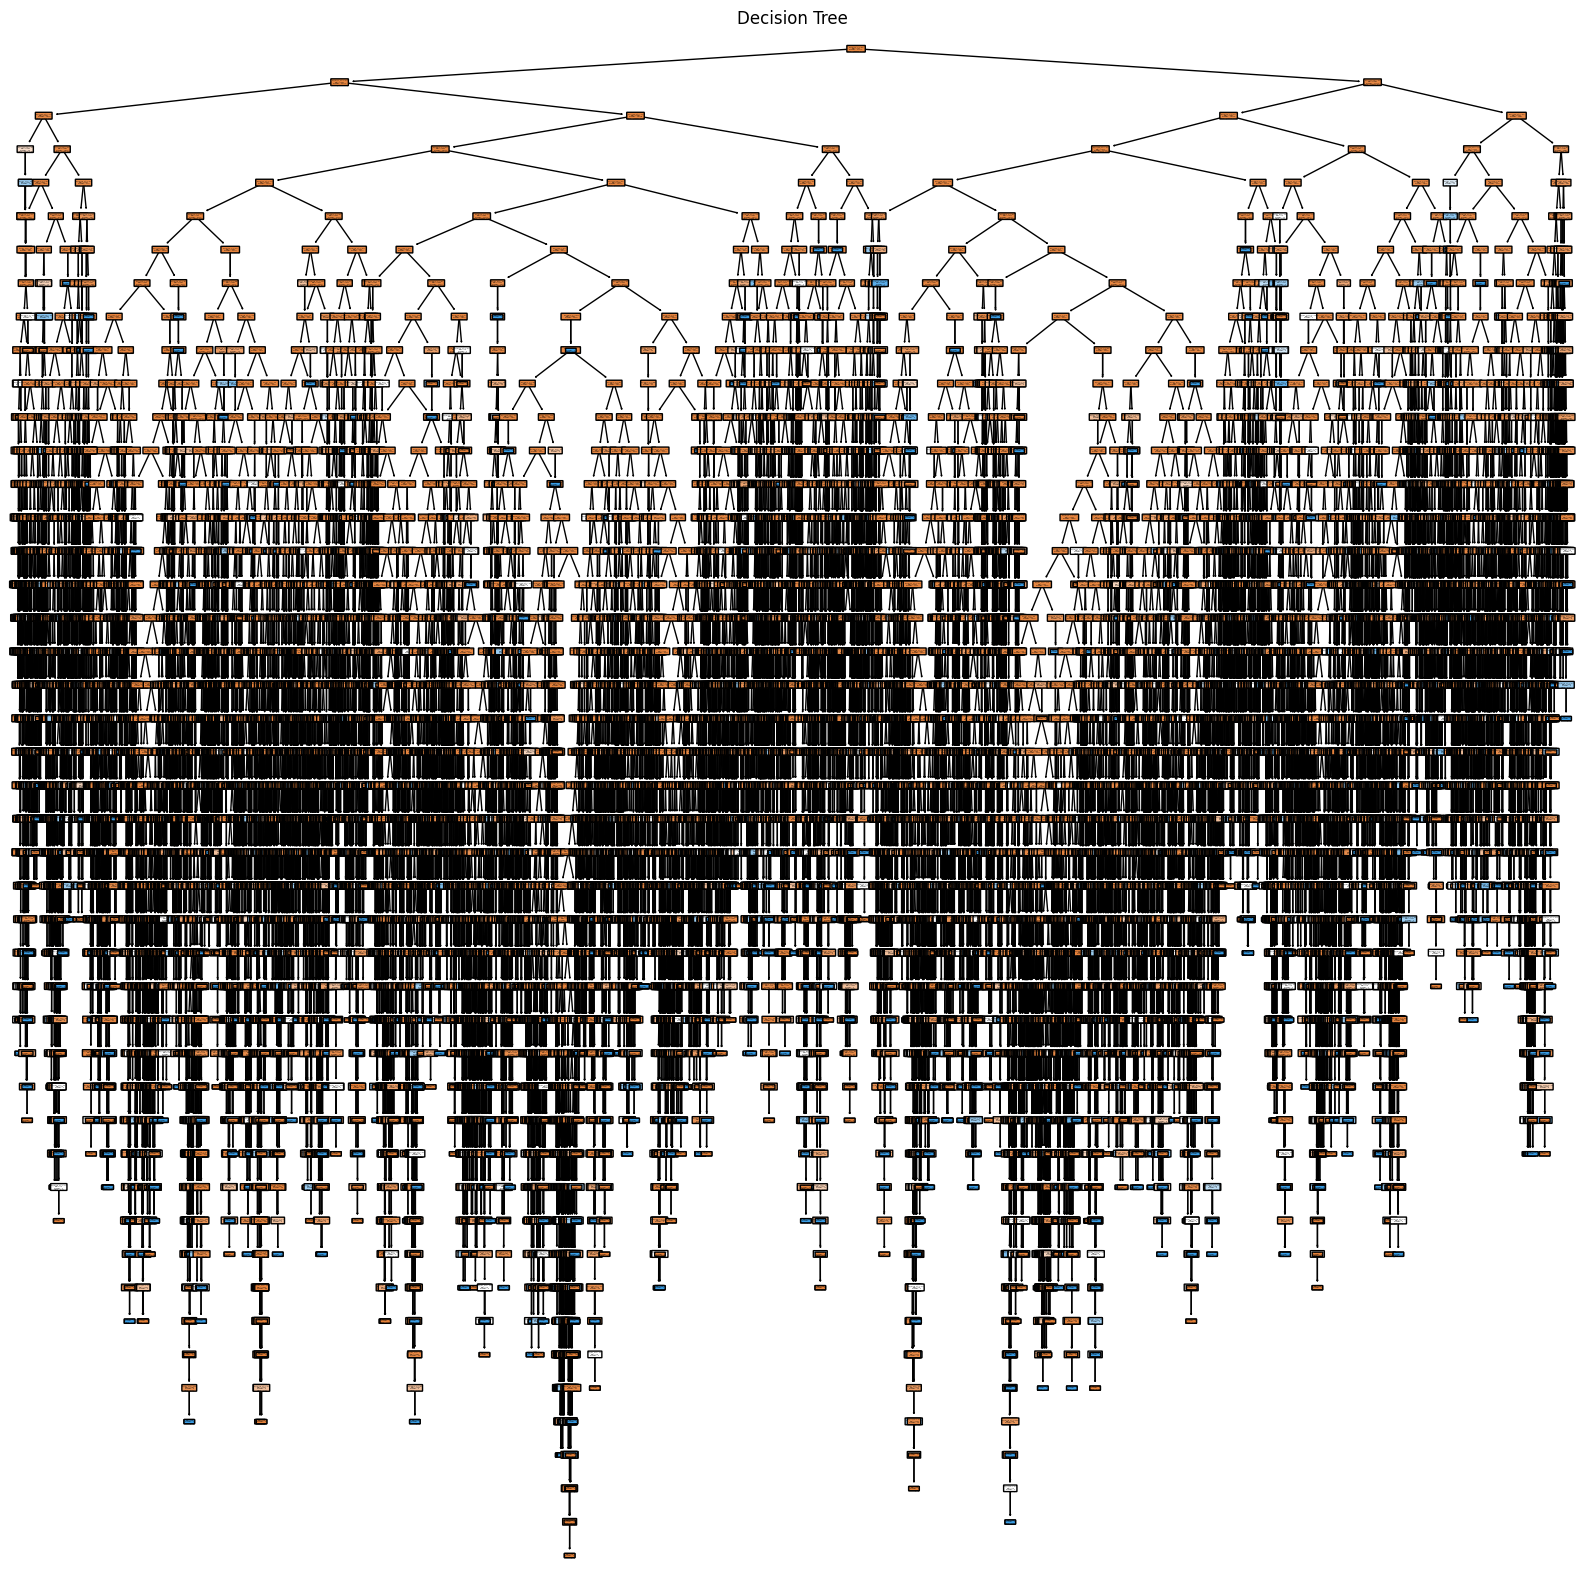

In [53]:
fig, ax = plt.subplots(figsize=(20, 20))

plot_tree(dt_model, feature_names=feature_cols, filled=True, rounded=True, ax=ax)

plt.title("Decision Tree")
plt.savefig("decision_tree.png")
plt.show()

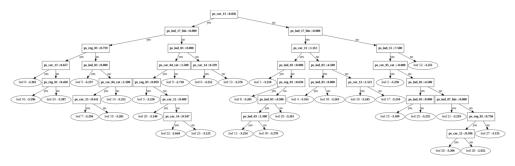

In [55]:
lgb.plot_tree(lgb_model, orientation="vertical")
plt.savefig("lgbm_tree.png")
plt.show()